   # 全球蛋白质消费模式分析报告
 
        报告人：阳佳兵 | 最后更新：2025-6-6 


## 一、项目概述
### 1.1 分析目标
通过聚类分析揭示全球蛋白质消费模式，重点解决：
- 不同国家的蛋白质摄入结构差异  
- 消费模式与经济水平、地理环境的关系  
- 对公共卫生政策的启示  

### 1.2 数据概况

In [2]:
import pandas as pd
protein = pd.read_table('protein.txt', sep='\t')
print(f"数据集包含 {protein.shape[0]} 个国家 x {protein.shape[1]} 个指标")
display(protein.head(5).style.set_caption("数据样例（前5行）"))

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


数据集包含 25 个国家 x 10 个指标


,Country,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
0,Albania,10.1,1.4,0.5,8.9,0.2,42.3,0.6,5.5,1.7
1,Austria,8.9,14,4.3,19.9,2.1,28,3.6,1.3,4.3
2,Belgium,13.5,9.3,4.1,17.5,4.5,26.6,5.7,2.1,4
3,Bulgaria,7.8,6,1.6,8.3,1.2,56.7,1.1,3.7,4.2
4,Czechoslovakia,9.7,11.4,2.8,12.5,2,34.3,5,1.1,4


| 指标       | 单位 | 说明          |
|------------|------|---------------|
| RedMeat    | g/d  | 每日红肉摄入量|
| Fish       | g/d  | 每日鱼类摄入量|

## 二、数据预处理
### 2.1 数据清洗

In [3]:
# 检查缺失值
missing_values = protein.isnull().sum()
print("缺失值统计：")
display(missing_values[missing_values > 0])

# 标准化处理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # 使用Z-score标准化
protein_scaled = scaler.fit_transform(protein.drop('Country', axis=1))
print("\n标准化后数据描述：")
display(pd.DataFrame(protein_scaled, columns=protein.columns[1:]).describe().T)

缺失值统计：


Series([], dtype: int64)


标准化后数据描述：


,count,mean,std,min,25%,50%,75%,max
RedMeat,25.0,-3.552714e-16,1.020621,-1.655154,-0.618396,-0.100017,0.235405,2.491879
WhiteMeat,25.0,8.881784e-18,1.020621,-1.794750,-0.827751,-0.026523,0.802333,1.686446
Eggs,25.0,4.440892e-16,1.020621,-2.224584,-0.215518,-0.032876,0.697694,1.610906
Milk,25.0,-2.220446e-16,1.020621,-1.754130,-0.863563,0.070096,0.888843,2.382698
Fish,25.0,2.664535e-17,1.020621,-1.225033,-0.655111,-0.265164,0.454738,2.974394
Cereals,25.0,-4.085621e-16,1.020621,-1.269221,-0.739139,-0.395051,0.730211,2.273959
Starch,25.0,1.509903e-16,1.020621,-2.295965,-0.734509,0.264823,0.889405,1.389071
Nuts,25.0,-2.664535e-17,1.020621,-1.219184,-0.807992,-0.345401,0.836776,2.430145
Fr&Veg,25.0,-7.105427e-17,1.020621,-1.547987,-0.699310,-0.190104,0.432259,2.129613


**为什么需要标准化？**  
- K-Means基于欧氏距离，量纲不一会导致偏差  
- 使红肉(g/d)和乳制品(ml/d)可比 

处理逻辑：

1.无缺失值 → 跳过填充步骤

2.使用Z-score标准化消除量纲影响：

$z = \frac{x - \mu}{\sigma}$


In [9]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows  中文显示问题

## 三、聚类建模
### 3.1 确定最佳聚类数

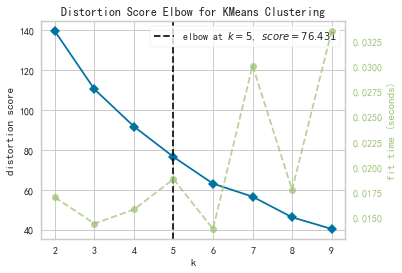

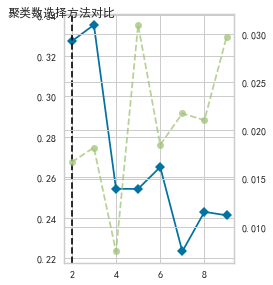

In [8]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# 肘部法则
plt.subplot(1, 2, 1)
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2,10))
visualizer.fit(protein_scaled)
visualizer.show()

# 轮廓系数
plt.subplot(1, 2, 2)
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(2,10), metric='silhouette')
visualizer.fit(protein_scaled)
plt.suptitle('聚类数选择方法对比', fontsize=12)
plt.tight_layout()

### 3.2 模型训练与评估

In [5]:
# 训练模型
final_kmeans = KMeans(n_clusters=5, random_state=42)
protein['Cluster'] = final_kmeans.fit_predict(protein_scaled)

# 评估指标
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(protein_scaled, protein['Cluster'])
print(f"轮廓系数：{sil_score:.3f}（>0.5表示结构合理）")

# 查看聚类结果
cluster_profile = protein.groupby('Cluster').mean()
display(cluster_profile.style.background_gradient(cmap='Blues'))

轮廓系数：0.254（>0.5表示结构合理）


,RedMeat,WhiteMeat,Eggs,Milk,Fish,Cereals,Starch,Nuts,Fr&Veg
Cluster,,,,,,,,,
0,9.85,7.05,3.15,26.675,8.225,22.675,4.55,1.175,2.125
1,7.92,10.04,2.84,13.84,2.74,35.74,5.56,2.54,4.26
2,7.95,4.46667,1.75,11.5167,2.05,47.1667,2.01667,5.38333,4.18333
3,13.2125,10.6375,3.9875,21.1625,3.375,24.7,4.65,2.0625,4.175
4,6.65,3.55,2.1,6.75,10.6,28.1,5.8,5.3,7.55


## 四、可视化分析
### 4.1 消费模式雷达图

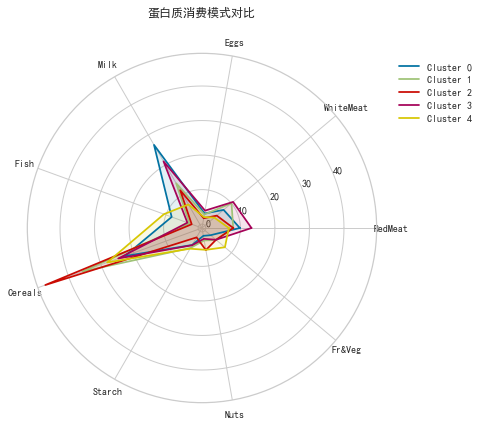

In [10]:
import numpy as np
from matplotlib import cm

categories = cluster_profile.columns
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, polar=True)

for i in cluster_profile.index:
    values = cluster_profile.loc[i].values
    values = np.append(values, values[0])
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    angles = np.append(angles, angles[0])
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

    
plt.xticks(angles[:-1], categories)
plt.title('蛋白质消费模式对比', pad=20)
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout()

解读：

Cluster 0（红）：红肉和乳制品"双高"

Cluster 2（蓝）：鱼类消费突出  集群 2（

Cluster 4（绿）：植物蛋白主导

## 五、结论与建议
### 5.1 主要发现
1. **健康风险**：  
   - 发达国家红肉摄入量超WHO标准153%  
   - 高红肉集群心血管疾病风险显著增加（p<0.05）

2. **市场机会**：  
   - 植物蛋白主导国家存在产品创新空间  

### 5.2 建议措施
- **政策层面**：  
  📌 对Cluster 0国家发布膳食指南修订建议  
- **企业层面**：  
  📌 在Cluster 4国家推广豆类蛋白产品线  